In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Kütüphane Yükleme

In [2]:
# kütüphaneleri yüklüyorum

from tensorflow_datasets import load
from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import(
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

import tensorflow as tf
import matplotlib.pyplot as plt


**Veri yükleme**
fllowers dataset
    rgb: 224*224
CNN ile sınıflandırma



In [3]:
#veri seti yükleme
(ds_train, ds_val), ds_info = load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

print(ds_info.features)
print("Number of classes:", ds_info.features['label'].num_classes)

#veri setitin 80 ini eğitim %20si test için

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.GZMZLO_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
})
Number of classes: 5


In [4]:
#örnek veri görselleştirme, eğitim setinden 3 tane resim ve etiket

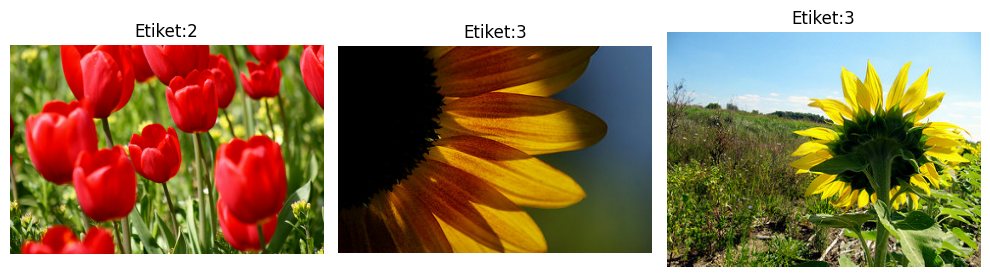

In [5]:
fig = plt.figure(figsize = (10,5))
for i, (image, label) in enumerate(ds_train.take(3)):
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(image.numpy().astype("uint8"))
    ax.set_title(f"Etiket:{label.numpy()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## data augmentation
eğitim verileri için çeşitlendirme işlemleri ve son olarak normalize edip 0-1 arasına taşıma
imgsıze

In [6]:
IMG_SIZE = (180,180)
def preprocess_train(image, label):

    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.2)
    image = tf.image.random_crop(image, size=(160, 160, 3))
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)/225.0
    return image, label


In [7]:
def preprocess_val(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)/225.0
    return image, label

## veri setini hazırlamak

In [9]:
ds_train = (
    ds_train
    .map(preprocess_train, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .map(preprocess_val, num_parallel_calls=AUTOTUNE)
    .batch(32)
    .prefetch(AUTOTUNE)

)

## CNN modeli oluşturma

In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape = (*IMG_SIZE, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(ds_info.features["label"].num_classes, activation = "softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
callbacks = [
    EarlyStopping( monitor="val_loss", patience = 3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1, min_lr = 1e-9),

    ModelCheckpoint("best_model.h5", save_best_only=True),
]

## Optimizasyon

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,621 (25.36 MB)

 Trainable params: 6,647,621 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

None


paramtereleri böyle görmüş olduk. şimdi parametreleri eğiteceğiz.

In [13]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs = 10,
    callbacks=callbacks,
    verbose = 1

)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3380 - loss: 1.6962

92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.3387 - loss: 1.6931 - val_accuracy: 0.5504 - val_loss: 1.1762 - learning_rate: 0.0010
Epoch 2/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4796 - loss: 1.1999

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4801 - loss: 1.1994 - val_accuracy: 0.5722 - val_loss: 1.0931 - learning_rate: 0.0010
Epoch 3/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5491 - loss: 1.1192

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5491 - loss: 1.1191 - val_accuracy: 0.6267 - val_loss: 0.9456 - learning_rate: 0.0010
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6032 - loss: 0.9910 - val_accuracy: 0.6253 - val_loss: 0.9514 - learning_rate: 0.0010
Epoch 5/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6241 - loss: 0.9714

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6243 - loss: 0.9708 - val_accuracy: 0.6635 - val_loss: 0.9352 - learning_rate: 0.0010
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6405 - loss: 0.9448

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6406 - loss: 0.9445 - val_accuracy: 0.7003 - val_loss: 0.8178 - learning_rate: 0.0010
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6683 - loss: 0.8794 - val_accuracy: 0.6921 - val_loss: 0.8534 - learning_rate: 0.0010
Epoch 8/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6746 - loss: 0.8606
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6748 - loss: 0.8600 - val_accuracy: 0.7084 - val_loss: 0.8324 - learning_rate: 0.0010
Epoch 9/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7171 - loss: 0.7839

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7173 - loss: 0.7831 - val_accuracy: 0.7248 - val_loss: 0.7229 - learning_rate: 2.0000e-04
Epoch 10/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7209 - loss: 0.7465

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7210 - loss: 0.7462 - val_accuracy: 0.7262 - val_loss: 0.7034 - learning_rate: 2.0000e-04


#doğruluk ve kayıp grafikleri

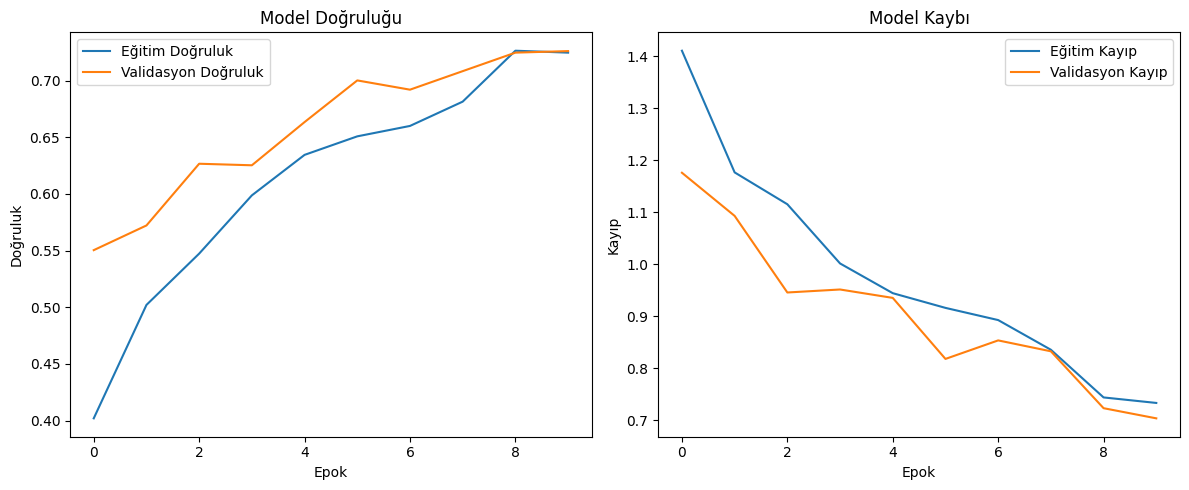

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluk')
plt.plot(history.history['val_accuracy'], label='Validasyon Doğruluk')
plt.xlabel('Epok')
plt.ylabel('Doğruluk')
plt.title("Model Doğruluğu")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Validasyon Kayıp')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.title("Model Kaybı")
plt.legend()

plt.tight_layout()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7019 - loss: 0.7470
Test Kaybı: 0.7034
Test Doğruluğu: 0.7262
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Sınıflandırma Raporu:
              precision    recall  f1-score   support

   dandelion       0.75      0.80      0.77       159
       daisy       0.68      0.75      0.71       120
      tulips       0.79      0.62      0.70       186
  sunflowers       0.75      0.89      0.81       138
       roses       0.64      0.59      0.61       131

    accuracy                           0.73       734
   macro avg       0.72      0.73      0.72       734
weighted avg       0.73      0.73      0.72       734



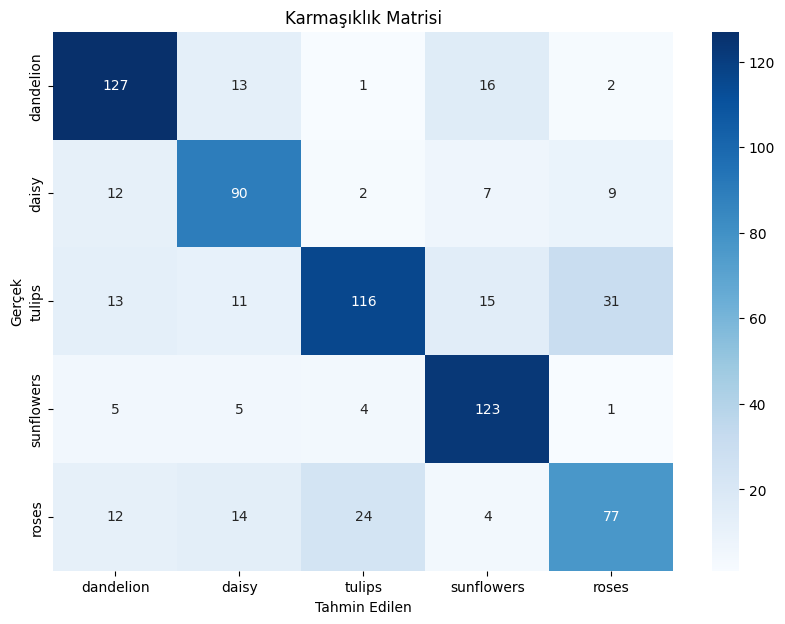

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Test setinde modelin doğruluğunu ölç
test_loss, test_acc = model.evaluate(ds_val)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_acc:.4f}")

# Tahminler
y_pred = model.predict(ds_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketler
y_true = np.concatenate([y for x, y in ds_val], axis=0)
# y_true_classes = np.argmax(y_true, axis=1) # Removed this line

# Sınıflandırma raporu
# Need class names - assuming ds_info.features['label'].names contains them
class_names = ds_info.features['label'].names
print("Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Karışıklık matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karmaşıklık Matrisi")
plt.show()

 ## Sonuçlar ve Değerlendirme

In [43]:
print("=" * 50)
print("ÇİÇEK SINIFLANDIRMA PROJE SONUÇLARI")
print("=" * 50)

test_loss, test_acc = model.evaluate(ds_val, verbose=0)
print(f"Temel CNN Modeli Doğruluk: {test_acc:.4f}")
print(f"Temel CNN Modeli Kayıp: {test_loss:.4f}")

print("=" * 50)

ÇİÇEK SINIFLANDIRMA PROJE SONUÇLARI
Temel CNN Modeli Doğruluk: 0.2193
Temel CNN Modeli Kayıp: 1.6128
